In [1]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet', include_top=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
base_dir = '../../../dataset/dist-unbalanced/train/'

In [4]:
import os

num_skipped = 0
for folder_name in ("accepted", "rejected"):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
IMG_SIZE = 224

In [6]:
size = (IMG_SIZE, IMG_SIZE)

In [7]:
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=size,
    batch_size=None
)

Found 28299 files belonging to 2 classes.
Using 22640 files for training.
Using 5659 files for validation.


In [8]:
NUM_CLASSES = 2

In [9]:
ds_train = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = val_ds.map(lambda image, label: (tf.image.resize(image, size), label))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [11]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


In [12]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [13]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("./models/efficient.h5", 
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    mode='max',
                                    verbose=1
                                   ),
]

353/353 [==============================] - 104s 279ms/step - loss: 0.6706 - accuracy: 0.8086 - val_loss: 0.4266 - val_accuracy: 0.8423


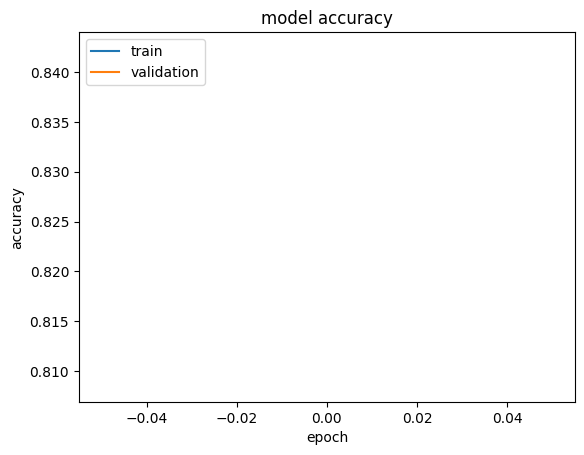

In [15]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 1
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)
plot_hist(hist)

In [19]:
model.save('./models/efficient.keras')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [18]:
loaded_model = keras.models.load_model('./models/efficient')

ValueError: Unable to create a Keras model from SavedModel at ./models/efficient. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

In [26]:
import numpy as np
img_path = np.random.choice(os.listdir(os.path.join(base_dir , "rejected")))

In [27]:
img_path

'76a52f7e-bf20-4a5c-bc72-a18ae6713173-scraped.jpg'

In [28]:
img = keras.preprocessing.image.load_img(
    os.path.join(base_dir,"rejected", img_path), target_size=size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 15ms/step
[[0.14092858 0.8590714 ]]


TypeError: only size-1 arrays can be converted to Python scalars

In [29]:
print(tf.__version__)

2.11.0
